## Prediction of Revenue Per Click

# Outline:

- Architecture
    - environment set-up:
        - `Pipenv`
        - `Spark`
        - `Jupyter`
        - `H2O`
- Set-up datasets using local spark warehouse
- `Spark:` Initial data exploration
    - target variable distribution
    - first hypotheses
    - data pre-processing
    - heavy feature engineering (leveraging Spark)
        - averages using window functions
        - removing non-significant keywords
    - data cleaning (simple operations that can be done in Spark)
- `H2O:`
    - variable encoding
    - outlier detection
    - leveraging `scikit-learn` for small scale pre-processing
    - set-up baseline model
        - mean model
    - develop more complex models (tracking performance with baseline to find the value of development)
- Summary
    - use AWS EC2 for reproducible and scalable model building
        - we might at some point try to use a cluster of machines for that
    - export **user settings** for the notebook
    - **create functions** from code that will be reused more than once
    - two stage models do not really work! (unless first level is very, very accurate)
    - Always use simpler model from the very beginning that will open the road to smart feature engineering
        - average rev per campaign
        - avreage rev per account etcc
    - All in all sampling and weighting can make a process much faste
    - Balancing is a good idea but not in two step models (too much to be done in the end)
    - Workflow with Sparkling water is very robust and enables to leverage a lot of Python libraries (scikit-learn, scipy)
    - deep learning is not super fast (even on fast machine) so for big datasets like this one would probably still use XGboost




In [1]:
# user settings
min_clicks_per_keyword = 100
pval_keyword = .01

import numpy as np
import pandas as pd
import sklearn


### Architecture details:

![alt text](https://i0.wp.com/blog.h2o.ai/wp-content/uploads/2017/04/hdi-image5.jpg?resize=700%2C394)

Note: also using `scikit-learn` utilities are much easier with H2O Data Frame than with pySpark (due to the unordered character of Spark DataFrame)

As a master node we are using AWS `t2.x2large` instance with following specs:

In [64]:
!sudo lshw -short

H/W path    Device  Class      Description
                    system     HVM domU
/0                  bus        Motherboard
/0/0                memory     96KiB BIOS
/0/401              processor  Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz
/0/402              processor  CPU
/0/403              processor  CPU
/0/404              processor  CPU
/0/405              processor  CPU
/0/406              processor  CPU
/0/407              processor  CPU
/0/408              processor  CPU
/0/1000             memory     32GiB System Memory
/0/1000/0           memory     16GiB DIMM RAM
/0/1000/1           memory     16GiB DIMM RAM
/0/100              bridge     440FX - 82441FX PMC [Natoma]
/0/100/1            bridge     82371SB PIIX3 ISA [Natoma/Triton II]
/0/100/1.1          storage    82371SB PIIX3 IDE [Natoma/Triton II]
/0/100/1.3          bridge     82371AB/EB/MB PIIX4 ACPI
/0/100/2            display    GD 5446
/0/100/3            generic    Xen Platform Device
/1          eth0    network  

### Data acquisition and ETL

In [5]:
# move tables from s3 to local sql warehouse
# spark.read.csv("s3n://jakubs-bucket/", header=True, inferSchema=True)
sdf_train = spark.read.csv("s3n://jakubs-bucket/rpc/train.csv", header=True, inferSchema=True)
sdf_train.persist()
sdf_train.count()

8285423

In [6]:
# spark.sql("drop table rpc.train")
# spark.sql('create database rpc');
sdf_train.write.saveAsTable('rpc.train')

#### Recover weighted binary response set

Since we want to model probability of success (conversion) and revenue seperately we need to recover original event dataset. Since h2o models can handle case weights natively we only need to recreate events groups that ended with conversion and without along with their counts and genereated revenue. 

In [15]:
# more conversions than clicks (information about detailed user path is lost in this aggregated dataset)
from pyspark.sql.functions import col

sdf.select('Conversions', 'Clicks').filter(col('Conversions') > col('Clicks')).count() /  \
    sdf.filter(col('Conversions') > 0).count()

0.03451276639078672

In [65]:
# sdf.select('Date', 'Clicks', 'Conversions', 'Revenue').show(5)

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, StructType, StructField, Row

# ?udf

@udf(returnType=ArrayType(
        StructType([
            StructField('n', IntegerType(), False),
            StructField('y', IntegerType(), False),
            StructField('m', DoubleType(), False),
            StructField('rpc', DoubleType(), False),
        ])))
def expand(clicks, conversions, revenue):
    
    if (conversions > clicks):
        conversions = clicks

    row0 = Row(n = clicks - conversions, y = 0, m = 0.0, rpc = revenue / clicks)
    if ((conversions > 0) & (conversions < clicks)):
            row1 = Row(n = conversions, y = 1, m = revenue / conversions, rpc = revenue / clicks)
            res = [row0, row1]
    elif ((conversions > 0) & (conversions == clicks)):
            row1 = Row(n = conversions, y = 1, m = revenue / conversions, rpc = revenue / clicks)
            res = [row1]
    else:
            res = [row0]
    return res



In [66]:
from pyspark.sql.functions import explode

sdf_exp = sdf \
    .withColumn('test', explode(expand(col('Clicks'), col('Conversions'), col('Revenue')))) \
    .withColumn('n', col('test.n')) \
    .withColumn('y', col('test.y')) \
    .withColumn('m', col('test.m')) \
    .withColumn('rpc', col('test.rpc')) \
    .drop('test')
    
sdf_exp.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- Keyword_ID: long (nullable = true)
 |-- Ad_group_ID: long (nullable = true)
 |-- Campaign_ID: long (nullable = true)
 |-- Account_ID: long (nullable = true)
 |-- Device_ID: long (nullable = true)
 |-- Match_type_ID: long (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Conversions: integer (nullable = true)
 |-- n: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- m: double (nullable = true)
 |-- rpc: double (nullable = true)



In [67]:
sdf_exp.select('Clicks','Conversions', 'Revenue', 'n').filter(col('n') == 0).show()

+------+-----------+-------+---+
|Clicks|Conversions|Revenue|  n|
+------+-----------+-------+---+
+------+-----------+-------+---+



In [68]:
spark.sql("drop table if exists rpc.train_exp")
sdf_exp.write.saveAsTable('rpc.train_exp')

In [73]:
sdf_exp.filter(col('y') == 1).select('Date', 'Keyword_ID', 'Clicks', 'Conversions', 'n', 'y', 'm', 'rpc').show()

+-------------------+------------+------+-----------+---+---+---------+------------------+
|               Date|  Keyword_ID|Clicks|Conversions|  n|  y|        m|               rpc|
+-------------------+------------+------+-----------+---+---+---------+------------------+
|2015-03-28 00:00:00|564236246447|     2|          2|  2|  1|  9950.27|           9950.27|
|2015-03-29 00:00:00|658432749877|     2|          2|  2|  1|  9502.06|           9502.06|
|2015-03-29 00:00:00|259046968052|     5|          2|  2|  1|  6050.84|2420.3360000000002|
|2015-03-29 00:00:00|470475977617|     2|          2|  2|  1|  3436.28|           3436.28|
|2015-03-29 00:00:00|116978882894|     2|          2|  2|  1|  1492.54|           1492.54|
|2015-03-30 00:00:00| 17294672432|     2|          2|  2|  1|  298.805|           298.805|
|2015-03-30 00:00:00|419112986726|     5|          2|  2|  1|  5790.88|          2316.352|
|2015-03-30 00:00:00|666290009790|     5|          2|  2|  1|  2562.27|          1024.908|

### Task description:

#### Advertiser programatic bidding:

 - The advertiser can set a price for each keyword/match type combination. 
 - She can even refine her price setting by taking the device (computer, mobile, ...) into account. 
 - She is furthermore free to update the prices whenever she wants. 

The set price mainly determines if her advertisement is shown to the user instead of a competitor’s one. Although the price decides on if the advertisement is shown, the advertiser only has to pay if the user clicks on the advertisement. A click redirects the user to the advertiser’s website offering him products that match what she was searching for. All the money the particular user spends in the next days on the advertiser’s website is attributed to the click, i.e. it is assumed that all the revenue the user generated with her conversions (=bookings, orders) after clicking on the advertisement was triggered by the advertisement.

#### Keyword taxonomy:

An online platform such as GetYourGuide provides easily thousands of products. Each product can have several relevant keywords such that the number of managed keywords is immense. Therefore, a hierarchy helps to categorize keywords:

 - **Keywords** belonging to the same product **are collected in an ad group**. 
 - Several ad groups can contain the same keyword, the combination of keyword and ad group is then again unique. 
 - **Ad groups** with a similar scope are bundled **in a campaign**. 
 - **Campaigns** for a common target audience are collected **in the same account**.

#### The question:

A crucial question to answer when pricing the keywords is how much revenue one can expect from a click. In other words, what is the expected Revenue per Click (RPC). Answering this question is your task in this test.

#### Evaluation metrics:

Click weighted squared distance:

$$ cost = \frac{1}{C} \sum_{i=1}^{N} \left[ c_n(r_n - \hat{r_n})^2 \right] $$

This means that we can drop all rows from dataset where number of click was zero...

### Data exploration

Tables were previously migrated from S3 bucket to the local spark metastore to speed up accessibility:

In [74]:
from pyspark.sql import SparkSession
spark = SparkSession \
        .builder \
        .appName('Jupyter') \
        .getOrCreate()

In [75]:
spark

In [76]:
!tree /home/ubuntu/spark-warehouse/

/home/ubuntu/spark-warehouse/
└── rpc.db
    ├── train
    │   ├── part-00000-8605fd82-a644-472a-baf9-34511d5143bc-c000.snappy.parquet
    │   ├── part-00001-8605fd82-a644-472a-baf9-34511d5143bc-c000.snappy.parquet
    │   ├── part-00002-8605fd82-a644-472a-baf9-34511d5143bc-c000.snappy.parquet
    │   ├── part-00003-8605fd82-a644-472a-baf9-34511d5143bc-c000.snappy.parquet
    │   ├── part-00004-8605fd82-a644-472a-baf9-34511d5143bc-c000.snappy.parquet
    │   ├── part-00005-8605fd82-a644-472a-baf9-34511d5143bc-c000.snappy.parquet
    │   ├── part-00006-8605fd82-a644-472a-baf9-34511d5143bc-c000.snappy.parquet
    │   ├── part-00007-8605fd82-a644-472a-baf9-34511d5143bc-c000.snappy.parquet
    │   └── _SUCCESS
    └── train_exp
        ├── part-00000-a9f5628e-fd39-428f-8ea5-f3876b409e6e-c000.snappy.parquet
        ├── part-00001-a9f5628e-fd39-428f-8ea5-f3876b409e6e-c000.snappy.parquet
        ├── part-00002-a9f5628e-fd39-428f-8ea5-f3876b409e6e-c000.snappy.parquet
        ├── part-00003-a9f

In [5]:
!df

Filesystem     1K-blocks    Used Available Use% Mounted on
udev            16465320       0  16465320   0% /dev
tmpfs            3294660    8772   3285888   1% /run
/dev/xvda1       8065444 4406204   3642856  55% /
tmpfs           16473284       0  16473284   0% /dev/shm
tmpfs               5120       0      5120   0% /run/lock
tmpfs           16473284       0  16473284   0% /sys/fs/cgroup
tmpfs            3294660      12   3294648   1% /run/user/1000


In [77]:
sdf = spark.sql("select * from rpc.train")
sdf.printSchema()
sdf.persist()
sdf.count()

root
 |-- Date: timestamp (nullable = true)
 |-- Keyword_ID: long (nullable = true)
 |-- Ad_group_ID: long (nullable = true)
 |-- Campaign_ID: long (nullable = true)
 |-- Account_ID: long (nullable = true)
 |-- Device_ID: long (nullable = true)
 |-- Match_type_ID: long (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Conversions: integer (nullable = true)



8285423

In [78]:
sdf_exp = spark.sql("select * from rpc.train_exp")
sdf_exp.printSchema()
sdf_exp.persist()
sdf_exp.count()

root
 |-- Date: timestamp (nullable = true)
 |-- Keyword_ID: long (nullable = true)
 |-- Ad_group_ID: long (nullable = true)
 |-- Campaign_ID: long (nullable = true)
 |-- Account_ID: long (nullable = true)
 |-- Device_ID: long (nullable = true)
 |-- Match_type_ID: long (nullable = true)
 |-- Revenue: double (nullable = true)
 |-- Clicks: integer (nullable = true)
 |-- Conversions: integer (nullable = true)
 |-- n: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- m: double (nullable = true)
 |-- rpc: double (nullable = true)



8362990

## Data Exploration

### Target variable

Hypotheses:

 - we can aggregate data over time, i.e. probability of Conversion is conditionaly independent of time
 - Revenue is conidtionaly-independent from probability of conversion &#9989;
 - Revenue does not depend on time?

where conditionality is on search keywords.

 - target variable is an compound distribution where we need to model conversion at all and conditionally respective revenue
 - probably we will just use glm model for that here with possibility of extending with tensorflow and rf for revenue
 - and normal rf as a baseline
 
 
 - we need to explode here !!!

### Target variables relationship:

In [79]:
from pyspark.sql.functions import col, log, sum
pdf = sdf \
        .withColumn('log_prob_of_conv', log(col('Conversions') / col('Clicks'))) \
        .withColumn('prob_of_conv', col('Conversions') / col('Clicks')) \
        .withColumn('log_of_revenue', log(1 + col('Revenue'))) \
        .withColumn('rpc', (col('Revenue') / col('Clicks'))) \
        .select('Clicks', 'Conversions' ,'log_prob_of_conv', 'log_of_revenue', 'rpc') \
        .sample(True, .01).toPandas()

In [8]:
pdf.corr()

,Clicks,Conversions,log_prob_of_conv,log_of_revenue,rpc
Clicks,1.000000,0.564717,-0.463962,0.185488,0.001264
Conversions,0.564717,1.000000,-0.085014,0.651360,0.290589
log_prob_of_conv,-0.463962,-0.085014,1.000000,-0.046746,0.346217
log_of_revenue,0.185488,0.651360,-0.046746,1.000000,0.517663
rpc,0.001264,0.290589,0.346217,0.517663,1.000000


In [9]:
pdf.describe()

,Clicks,Conversions,log_prob_of_conv,log_of_revenue,rpc
count,83149.000000,83149.000000,1696.000000,83149.000000,83149.000000
mean,3.391887,0.052183,-0.727868,0.174773,55.414120
std,6.557436,0.574474,0.960481,1.225395,823.720392
min,2.000000,0.000000,-4.559126,0.000000,0.000000
25%,2.000000,0.000000,-1.386294,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,0.000000,0.000000,0.000000,0.000000
max,658.000000,67.000000,1.704748,12.284635,108172.630000


In [10]:
pdf['rpc'].hist(bins=40)

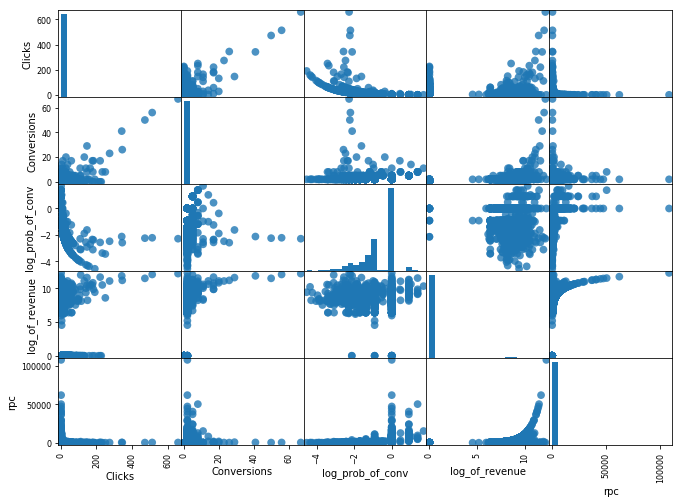

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

p = pd.plotting.scatter_matrix(pdf, figsize=(11, 8), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.8)

## Data preparation

TODO's:

 - explode and save spark data frame &#9989;
 - baseline model
 - maximum and minimum attainable accuracy
 - add weighting of classes as a parameter to be tunned
 - cleaning

#### Class balancing

In [80]:
tmp_0 = sdf_exp.filter(col('y')==0).agg(sum(col('n')).alias('n')).collect()[0].n
tmp_1 = sdf_exp.filter(col('y')==1).agg(sum(col('n')).alias('n')).collect()[0].n
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage before weighting: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

Class percentage before weighting: Y==1: 1.38%, Y==0: 98.62%


In [81]:
# class weights
N = tmp_0 + tmp_1
w_0 = N * .5 / tmp_0
w_1 = N * .5 / tmp_1

In [82]:
from pyspark.sql.functions import when

sdf_exp_w = sdf_exp \
            .withColumn('n_orig', col('n')) \
            .withColumn('n', when(col('y') == 1, col('n') * w_1).otherwise(col('n') * w_0))
    
tmp_0 = sdf_exp_w.filter(col('y')==0).agg(sum(col('n')).alias('n')).collect()[0].n
tmp_1 = sdf_exp_w.filter(col('y')==1).agg(sum(col('n')).alias('n')).collect()[0].n
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage after balancing: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

Class percentage after balancing: Y==1: 50.00%, Y==0: 50.00%


#### Maximum attainable accuracy (Move to the baseline setting)

$$ \frac{1}{C} \sum_{n = 1}^N c_n * \mathrm{max}_y\{c(y) \} $$

where $c(y)$ is a number of click events that ended with state $y$.

In [83]:
from pyspark.sql.functions import when

tmp = sdf_exp_w \
    .groupBy('Date', 'Keyword_ID', 'Match_type_ID') \
    .agg(*[sum('n').alias('Clicks'), sum(when(col('y')==1, col('n')).otherwise(0)).alias('Conversions')]) \
    .select('Conversions', 'Clicks') \
    .withColumn('score', when((col('Clicks') - col('Conversions')) > col('Conversions'), 
                              col('Clicks') - col('Conversions')).otherwise(col('Conversions'))) \
    .agg(sum(col('score')).alias('score'), sum(col('Clicks')).alias('Clicks')) \
    .collect()
    
print('Minimum possible error: {:2.2f}%'.format(100 - tmp[0].score / tmp[0].Clicks * 100) )

Minimum possible error: 5.58%


#### Minimum attainable accuracy

- when we always assume lack of conversion

In [84]:
tmp = sdf_exp_w \
    .groupBy('Date', 'Keyword_ID', 'Match_type_ID') \
    .agg(*[sum('n').alias('Clicks'), sum(when(col('y')==1, col('n')).otherwise(0)).alias('Conversions')]) \
    .select('Conversions', 'Clicks') \
    .withColumn('score', col('Clicks') - col('Conversions')) \
    .agg(sum(col('score')).alias('score'), sum(col('Clicks')).alias('Clicks')) \
    .collect()
    
print('Class majority error: {:2.2f}%'.format(100 - tmp[0].score / tmp[0].Clicks * 100) )

Class majority error: 50.00%


### Average probability of conversion over time

In [85]:
tmp = sdf \
        .groupBy('Date') \
        .agg(*[sum(col('Conversions')).alias('Conversions'), 
           sum(col('Clicks')).alias('Clicks'), 
           sum(col('Revenue')).alias('Revenue')]) \
        .withColumn('log_prob_of_conv', log(col('Conversions') / col('Clicks'))) \
        .withColumn('prob_of_conv', col('Conversions') / col('Clicks')) \
        .withColumn('log_of_revenue', log(1 + col('Revenue'))) \
        .withColumn('rpc', log(col('Revenue') / col('Clicks'))) \
        .orderBy(col('Date').asc()) \
        .toPandas()

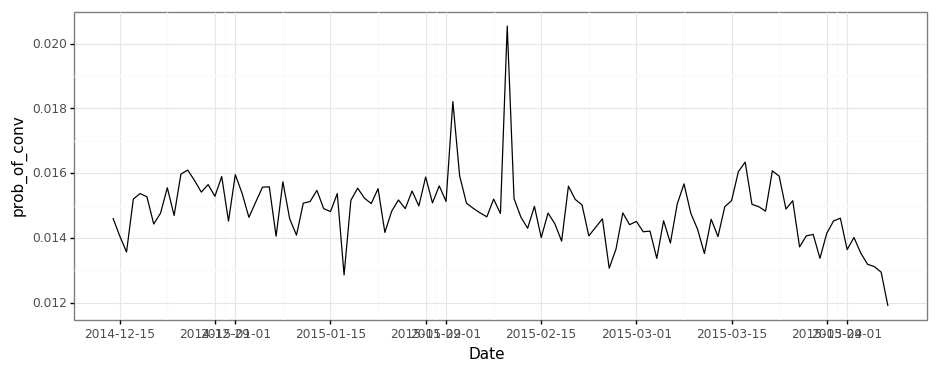

<ggplot: (-9223363258078880382)>

In [16]:
from plotnine import ggplot, geom_line, aes, theme_bw
import plotnine
plotnine.options.figure_size = (11, 4)


ggplot(aes(x='Date', y='prob_of_conv'), data=tmp) + geom_line() + theme_bw()

### Remove rare keywords using Chi-Square test of independence

In [86]:
from pyspark.sql.functions import pow

tmp = sdf_exp_w \
        .select('Keyword_ID', 'y', 'n') \
        .groupBy('Keyword_ID', 'y') \
        .agg(sum(col('n')).alias('n')) \
        .groupBy('Keyword_ID') \
        .pivot('y', [0, 1]).sum('n') \
        .withColumn('1', when(col('1').isNull(), 0.0).otherwise(col('1'))) \
        .withColumn('n', col('0') + col('1')) \
        .withColumn('X', pow(col('0') - col('n') * .5, 2) / (col('n') * .5) * 2.0) \
        .orderBy(col('n').desc()) \
        .persist()
        
tmp.show(5)
tmp.count()

+------------+-----------------+------------------+------------------+------------------+
|  Keyword_ID|                0|                 1|                 n|                 X|
+------------+-----------------+------------------+------------------+------------------+
|224325004348|97506.51582920473| 634419.9224103128| 731926.4382395175| 393859.2611300016|
|168388674416|71210.18583206876|509118.08679383865| 580328.2726259074| 330439.4060572648|
|421241223812|39691.90397693723| 173818.6483066635|213510.55228360073| 84258.05353449749|
|981509692733|27850.74789971986| 54359.15139110278| 82209.89929082264| 8547.577137591827|
|928382372783|18634.25636316675|  60673.2317262509| 79307.48808941766|22283.840935491844|
+------------+-----------------+------------------+------------------+------------------+
only showing top 5 rows



487981

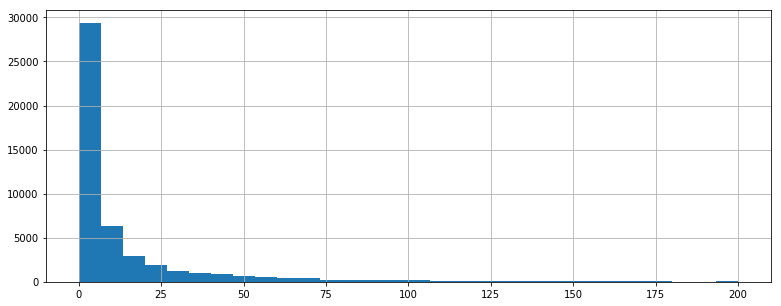

In [87]:
tmp.select('X').sample(fraction=.1, withReplacement=False, seed=2014).toPandas()['X'] \
    .hist(bins=30, figsize=(13, 5), range=[0, 200])


https://en.wikipedia.org/wiki/Chi-squared_distribution#Table_of_χ2_values_vs_p-values

In [90]:
# very at least 100 searches and Pval<.01

print(tmp.count())
print(tmp.filter(col('X') > 3.84).count())
print(tmp.filter((col('n') > 100)).count())
print(tmp.filter((col('X') > 6.63) & (col('n') > 100)).count())

487981
258954
42264
34685


In [91]:
# create sdf with pruned keyword variable

from pyspark.sql.functions import lit
sdf_rm_keywords = tmp.filter((col('X') > 6.63) & (col('n') > 100)).select('Keyword_ID').withColumn("valid", lit(1)).persist()
sdf_rm_keywords.count()

34685

In [92]:
sdf_exp_w_r = sdf_exp_w.alias('A') \
        .join(sdf_rm_keywords.alias('B'), col('A.Keyword_ID') == col('B.Keyword_ID'), how='left') \
        .withColumn('valid', when(col('valid').isNull(), 0).otherwise(col('valid'))) \
        .drop(col('B.Keyword_ID')) \
        .withColumn('Keyword_ID_r', when(col('valid') == 1, col('Keyword_ID')).otherwise(0)) \
        .drop('valid') \
        .persist()
        
sdf_exp_w_r.count()

8362990

### Remove rare groups using Chi-Square test of independence

In [93]:
from pyspark.sql.functions import pow

cat_var = 'Ad_group_ID'
tmp = sdf_exp_w \
        .select(cat_var, 'y', 'n') \
        .groupBy(cat_var, 'y') \
        .agg(sum(col('n')).alias('n')) \
        .groupBy(cat_var) \
        .pivot('y', [0, 1]).sum('n') \
        .withColumn('1', when(col('1').isNull(), 0.0).otherwise(col('1'))) \
        .withColumn('n', col('0') + col('1')) \
        .withColumn('X', pow(col('0') - col('n') * .5, 2) / (col('n') * .5) * 2.0) \
        .orderBy(col('n').desc()) \
        .persist()
        
tmp.show(5)
tmp.count()

+------------+------------------+------------------+------------------+------------------+
| Ad_group_ID|                 0|                 1|                 n|                 X|
+------------+------------------+------------------+------------------+------------------+
|855373402534|  97725.5336158703| 653217.0121436848| 750942.5457595551|  410911.306676475|
|401896054132| 53062.12867587447|342484.42645475786|395546.55513063236|211770.94166309838|
|474873553865|24156.850692209733|102331.64681102117| 126488.4975032309| 48315.05527260797|
|143615983355|21134.202441979825|  90429.2425010868|111563.44494306663|43041.003074472195|
|807562570330|11139.487982900284| 97396.50356056057|108535.99154346086| 68551.20251410276|
+------------+------------------+------------------+------------------+------------------+
only showing top 5 rows



269480

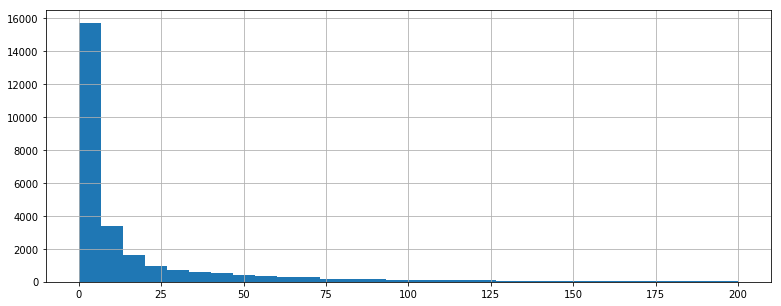

In [94]:
tmp.select('X').sample(fraction=.1, withReplacement=False, seed=2014).toPandas()['X'] \
    .hist(bins=30, figsize=(13, 5), range=[0, 200])


https://en.wikipedia.org/wiki/Chi-squared_distribution#Table_of_χ2_values_vs_p-values

In [95]:
# very at least 100 searches and Pval<.01

print(tmp.count())
print(tmp.filter(col('X') > 3.84).count())
print(tmp.filter((col('n') > 100)).count())
print(tmp.filter((col('X') > 6.63) & (col('n') > 100)).count())

269480
146976
31957
26431


In [96]:
# create sdf with pruned keyword variable

from pyspark.sql.functions import lit
sdf_rm_keywords = tmp.filter((col('X') > 6.63) & (col('n') > 100)).select(cat_var).withColumn("valid", lit(1)).persist()
sdf_rm_keywords.count()

26431

In [97]:
sdf_exp_w_r = sdf_exp_w_r.alias('A') \
        .join(sdf_rm_keywords.alias('B'), col('A.' + cat_var) == col('B.' + cat_var), how='left') \
        .withColumn('valid', when(col('valid').isNull(), 0).otherwise(col('valid'))) \
        .drop(col('B.' + cat_var)) \
        .withColumn(cat_var + '_r', when(col('valid') == 1, col(cat_var)).otherwise(0)) \
        .persist()
        
sdf_exp_w_r.count()

8362990

### Clean the data

In [98]:
# remove 0.0$ conversions
m_n_0 = sdf_exp_w_r.filter((col('y') > 0) & (col('m') == 0)).count()
m_n = sdf_exp_w_r.filter((col('y') > 0)).count()

print('Removing 0.0$ conversions: {} ({:2.2f}%)'.format(m_n_0, m_n_0 / m_n * 100))

ff = ((col('y') > 0) & (col('m') > 0)) | (col('y') == 0)
sdf_exp_w_r = sdf_exp_w_r.filter(ff).persist()
sdf_exp_w_r.count()

Removing 0.0$ conversions: 1378 (0.85%)


8361612

### Import data to h2o DataFrame

In [99]:
import h2o
from pysparkling import H2OContext
hc = H2OContext.getOrCreate(spark)

Connecting to H2O server at http://172.31.46.219:54321... successful.


H2O cluster uptime:,51 mins 29 secs
H2O cluster version:,3.16.0.2
H2O cluster version age:,1 month and 4 days
H2O cluster name:,sparkling-water-ubuntu_local-1515074242855
H2O cluster total nodes:,1
H2O cluster free memory:,10.51 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"
H2O connection url:,http://172.31.46.219:54321
H2O connection proxy:,None



Sparkling Water Context:
 * H2O name: sparkling-water-ubuntu_local-1515074242855
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,172.31.46.219,54321)
  ------------------------

  Open H2O Flow in browser: http://172.31.46.219:54321 (CMD + click in Mac OSX)

    


In [108]:
h2o.remove_all()
df = hc.as_h2o_frame(sdf_exp_w_r, framename='sdf_exp_w_r')

In [109]:
df['Keyword_ID'] = df['Keyword_ID'].asfactor()
df['Keyword_ID_r'] = df['Keyword_ID_r'].asfactor()
df['Ad_group_ID'] = df['Ad_group_ID'].asfactor()
df['Ad_group_ID_r'] = df['Ad_group_ID_r'].asfactor()
df['Campaign_ID'] = df['Campaign_ID'].asfactor()
df['Match_type_ID'] = df['Match_type_ID'].asfactor()
df['Device_ID'] = df['Device_ID'].asfactor()

df['Month'] = df['Date'].month().asfactor()
df['Week'] = df['Date'].week().asfactor()
df['Day'] = df['Date'].dayOfWeek().asfactor()

df['rpc'] = df['rpc'].asnumeric()

df['y'] = df['y'].asfactor()

In [110]:
df.names

['Date',
 'Keyword_ID',
 'Ad_group_ID',
 'Campaign_ID',
 'Account_ID',
 'Device_ID',
 'Match_type_ID',
 'Revenue',
 'Clicks',
 'Conversions',
 'n',
 'y',
 'm',
 'rpc',
 'n_orig',
 'Keyword_ID_r',
 'valid',
 'Ad_group_ID_r',
 'Month',
 'Week',
 'Day']

### Detect outliers of m - on logarithmic scale (average Revenue per conversion)

In [111]:
tmp = df[['m', 'y']].as_data_frame()
len(tmp)
tmp.head()

,m,y
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0


In [112]:
# take log where it is positive, else we put NaN to capture possible errors when using wrong values
tmp.loc[tmp['y'] > 0, 'log_m'] = np.log(tmp[tmp['y'] > 0]['m'])
tmp.describe()

,m,y,log_m
count,8.361612e+06,8.361612e+06,160649.000000
mean,7.656375e+01,1.921268e-02,7.847454
std,8.807943e+02,1.372718e-01,0.970534
min,0.000000e+00,0.000000e+00,2.010895
25%,0.000000e+00,0.000000e+00,7.220403
50%,0.000000e+00,0.000000e+00,7.899241
75%,0.000000e+00,0.000000e+00,8.527111
max,5.148236e+05,1.000000e+00,13.151580


In [113]:
# remove outliers using EllipticEnvelope
from sklearn.covariance import EllipticEnvelope

ee = EllipticEnvelope()
ee.fit(tmp[tmp['y'] > 0][['log_m']])
tmp.loc[tmp['y'] > 0, 'outlier'] = ee.predict(tmp[tmp['y'] > 0][['log_m']])
tmp.describe()

,m,y,log_m,outlier
count,8.361612e+06,8.361612e+06,160649.000000,160649.000000
mean,7.656375e+01,1.921268e-02,7.847454,0.800098
std,8.807943e+02,1.372718e-01,0.970534,0.599871
min,0.000000e+00,0.000000e+00,2.010895,-1.000000
25%,0.000000e+00,0.000000e+00,7.220403,1.000000
50%,0.000000e+00,0.000000e+00,7.899241,1.000000
75%,0.000000e+00,0.000000e+00,8.527111,1.000000
max,5.148236e+05,1.000000e+00,13.151580,1.000000


outlier
-1.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
 1.0    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

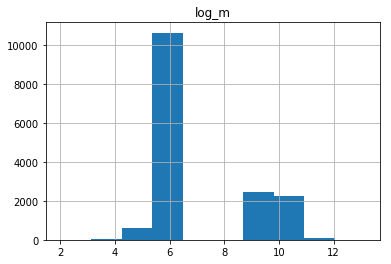

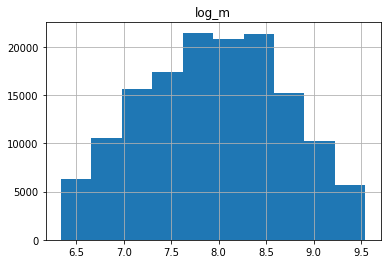

In [114]:
tmp[tmp['y'] > 0][['log_m', 'outlier']].groupby('outlier').hist()

In [115]:
tmp.loc[np.isnan(tmp['outlier']), 'outlier'] = 0
tmp.describe()

,m,y,log_m,outlier
count,8.361612e+06,8.361612e+06,160649.000000,8.361612e+06
mean,7.656375e+01,1.921268e-02,7.847454,1.537204e-02
std,8.807943e+02,1.372718e-01,0.970534,1.377548e-01
min,0.000000e+00,0.000000e+00,2.010895,-1.000000e+00
25%,0.000000e+00,0.000000e+00,7.220403,0.000000e+00
50%,0.000000e+00,0.000000e+00,7.899241,0.000000e+00
75%,0.000000e+00,0.000000e+00,8.527111,0.000000e+00
max,5.148236e+05,1.000000e+00,13.151580,1.000000e+00


In [116]:
# merge back with h2o df:
df_out_m = h2o.H2OFrame(tmp[['outlier']])

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [117]:
df = df.cbind(df_out_m)
df.names

['Date',
 'Keyword_ID',
 'Ad_group_ID',
 'Campaign_ID',
 'Account_ID',
 'Device_ID',
 'Match_type_ID',
 'Revenue',
 'Clicks',
 'Conversions',
 'n',
 'y',
 'm',
 'rpc',
 'n_orig',
 'Keyword_ID_r',
 'valid',
 'Ad_group_ID_r',
 'Month',
 'Week',
 'Day',
 'outlier']

### Test, Train, Validate

Few comments about splitting the dataset (date and Keyword are the key)

In [118]:
train, validate, test = df[df['outlier'] > -1, :].split_frame([.8, .1], seed=2014)

predictors = ['Keyword_ID_r', 'Ad_group_ID_r', 'Campaign_ID', 
              'Account_ID', 'Match_type_ID', 'Device_ID', 'Month', 'Day', 'Week']
response = 'y'
weights_col = 'n'

### Model building process

We keep track of the progress with respect to the 'trivial model' to evaluate dimnishing returns of model exploration process:

- majority class assignment for `y`
- dataset average for `m`

Note: We evaluate model bulding progress using validation set.

In [120]:
# trivial model predictions:

model_0_m_avg = (train[['m']] * train[['n']]).sum() / train[['n']].sum()
model_0_m_avg_uw = (train[['m']] * train[['n_orig']]).sum() / train[['n_orig']].sum()
print('Average revenue per click: {:.2f}$'.format(model_0_m_avg))
print('Average revenue per click (unweighted): {:.2f}$'.format(model_0_m_avg_uw))

validate['pred_revenue'] = model_0_m_avg
validate['pred_revenue_uw'] = model_0_m_avg_uw

# evaluate target metrics:

frame = validate
model_0_err1 = ((frame['pred_revenue'] - frame['rpc']) * (frame['pred_revenue'] - frame['rpc']) * frame['n']).sum() / frame['n'].sum()
model_0_err2 = np.sqrt(model_0_err1)

model_0_err1_uw = ((frame['pred_revenue_uw'] - frame['rpc']) * (frame['pred_revenue_uw'] - frame['rpc']) * frame['n_orig']).sum() / frame['n_orig'].sum()
model_0_err2_uw = np.sqrt(model_0_err1_uw)

print('RMSE: {:.2f}$'.format(model_0_err2))
print('RMSE (unweighted): {:.2f}$'.format(model_0_err2_uw))

Average revenue per click: 1692.10$
Average revenue per click (unweighted): 44.43$
RMSE: 2097.09$
RMSE (unweighted): 412.61$


### Model for `P[Conversion]`: Lasso Logistic regression

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

#### Tune lasso parameters

In [195]:
from h2o.grid import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

import numpy as np

lambda_grid = list(np.logspace(start=-7.0, stop=-3.0, num=10, base=10.0))

g = H2OGridSearch(
        model=H2OGeneralizedLinearEstimator(family="binomial", alpha=1.0),
        hyper_params={"lambda": lambda_grid},
        grid_id="glm_grid"
    )

g.train(predictors, response, training_frame=train, validation_frame=validate, weights_column = weights_col)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


/home/ubuntu/.local/share/virtualenvs/ml-rpc-LO9Wo36E/lib/python3.5/site-packages/h2o/job.py:69: UserWarning: Reached maximum number of iterations 50!
  warnings.warn(w)


In [196]:
import pandas as pd
pd_auc = pd.DataFrame(list(g.auc().items()), columns=['Model_ID', 'AUC']).sort_values('AUC', ascending=False)
model_ids = pd_auc['Model_ID'].values
pd_auc['lambda'] = np.array([g.get_hyperparams_dict(model, display=False)['lambda'] for model in model_ids])
pd_auc = pd_auc.sort_values('AUC', ascending=False)

pd_auc

# select best model and remove the rest
# h2o.remove_all()

,Model_ID,AUC,lambda
7,glm_grid_model_5,0.785573,1.668101e-05
3,glm_grid_model_1,0.774179,2.782559e-07
6,glm_grid_model_0,0.773101,1.000000e-07
2,glm_grid_model_2,0.768700,7.742637e-07
5,glm_grid_model_6,0.767554,4.641589e-05
4,glm_grid_model_3,0.763050,2.154435e-06
8,glm_grid_model_4,0.756216,5.994843e-06
1,glm_grid_model_7,0.750369,1.291550e-04
9,glm_grid_model_8,0.733851,3.593814e-04
0,glm_grid_model_9,0.719154,1.000000e-03


In [121]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_model = H2OGeneralizedLinearEstimator(family="binomial", 
                                          lambda_=1.668101e-05, 
                                          standardize=True,
                                          alpha=1.0,
                                          max_iterations=100)

glm_model.train(predictors, response, training_frame=train, validation_frame=validate, weights_column = 'n')

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [122]:
glm_model.model_performance(train).confusion_matrix(metrics='accuracy', thresholds=[.5])

Could not find exact threshold 0.5; using closest threshold found 0.5006957587542978.
Confusion Matrix (Act/Pred) @ threshold = 0.5006957587542978: 


,0,1,Error,Rate
0,8394824.0,2825344.0,0.2518,(2825344.0/11220168.0)
1,3270113.0,6860828.0,0.3228,(3270113.0/10130941.0)
Total,11664937.0000000,9686172.0,0.2855,(6095457.0/21351109.0)


Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.5028807298090842: 


,0,1,Error,Rate
0,8425097.0,2795071.0,0.2491,(2795071.0/11220168.0)
1,3300123.0,6830818.0,0.3257,(3300123.0/10130941.0)
Total,11725220.0000000,9625889.0,0.2855,(6095194.0/21351109.0)


[, ]

In [59]:
glm_model.model_performance(validate).confusion_matrix(metrics='accuracy', thresholds=[.5])

Could not find exact threshold 0.5; using closest threshold found 0.49921668293114435.
Confusion Matrix (Act/Pred) @ threshold = 0.49921668293114435: 


,0,1,Error,Rate
0,1044987.0,354114.0,0.2531,(354114.0/1399101.0)
1,422390.0,840389.0,0.3345,(422390.0/1262779.0)
Total,1467377.0,1194503.0,0.2917,(776504.0/2661880.0)


Confusion Matrix (Act/Pred) for max accuracy @ threshold = 0.5274366964409944: 


,0,1,Error,Rate
0,1094220.0,304880.0,0.2179,(304880.0/1399100.0)
1,469455.0,793324.0,0.3718,(469455.0/1262779.0)
Total,1563675.0,1098204.0,0.2909,(774335.0/2661879.0)


[, ]

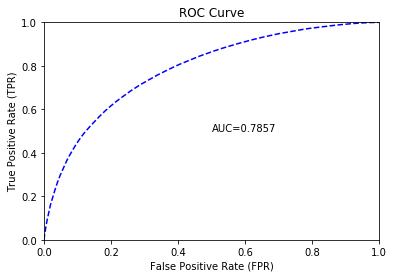

In [123]:
tmp = glm_model.model_performance(train)
from matplotlib import pyplot as plt
# plt.figure(figsize=(7, 7))
tmp.plot()

### Validate model:

We keep track of the progress with respect to the 'trivial model' to evaluate dimnishing returns of model exploration process:

- class assignment for `y` according to `P[Conversion]` with tuned threshold
- dataset average for `m`

In [136]:
model_0_m_avg_per_conv = (train[['m']] * train[['n']]).sum() / train[train['y']=='1', 'n'].sum()
print('Average revenue per conversion: {:.2f}$'.format(model_0_m_avg_per_conv))

glm_model_pred = glm_model.predict(validate)
glm_model_pred
validate['pred_revenue'] = model_0_m_avg_per_conv * glm_model_pred['p1']

pp = glm_model_pred['p1'].sum() / glm_model_pred['p1'].nrows
validate['pred_revenue_uw'] = model_0_m_avg_per_conv * (glm_model_pred['p1'] / pp * .0138)

# evaluate target metrics:

frame = validate
model_1_err1 = ((frame['pred_revenue'] - frame['rpc']) * (frame['pred_revenue'] - frame['rpc']) * frame['n']).sum() / frame['n'].sum()
model_1_err2 = np.sqrt(model_1_err1)

model_1_err1_uw = ((frame['pred_revenue_uw'] - frame['rpc']) * (frame['pred_revenue_uw'] - frame['rpc']) * frame['n_orig']).sum() / frame['n_orig'].sum()
model_1_err2_uw = np.sqrt(model_1_err1_uw)

print('RMSE: {:.2f}$'.format(model_1_err2))
print('RMSE (unweighted): {:.2f}$'.format(model_1_err2_uw))

Average revenue per conversion: 3566.13$
glm prediction progress: |████████████████████████████████████████████████| 100%
RMSE: 2107.25$
RMSE (unweighted): 409.91$


In [137]:
# add offsets to df's
validate['offset'] = model_0_m_avg_per_conv * (glm_model.predict(validate)['p1'] / pp * .0138)
train['offset'] = model_0_m_avg_per_conv * (glm_model.predict(train)['p1'] / pp * .0138)
test['offset'] = model_0_m_avg_per_conv * (glm_model.predict(test)['p1'] / pp * .0138)

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%


### Model for `E[logm]`: Lasso Linear Regression

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

In [132]:
predictors = ['Keyword_ID_r', 'Ad_group_ID_r', 'Campaign_ID', 
              'Account_ID', 'Match_type_ID', 'Device_ID', 'Month', 'Day', 'Week']
response = 'rpc'
weights_col = 'n_orig'

#### Tune lasso parameters

In [244]:
from h2o.grid import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

import numpy as np

lambda_grid = list(np.logspace(start=-7.0, stop=-3.0, num=10, base=10.0))

h2o.remove('lm_grid')
g_lm = H2OGridSearch(
        model=H2OGeneralizedLinearEstimator(family="gaussian", alpha=1.0),
        hyper_params={"lambda": lambda_grid},
        grid_id="lm_grid"
    )

g_lm.train(predictors, response, training_frame=train_m, validation_frame=validate_m, weights_column = weights_col)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


/home/ubuntu/.local/share/virtualenvs/ml-rpc-LO9Wo36E/lib/python3.5/site-packages/h2o/job.py:69: UserWarning: Reached maximum number of iterations 50!
  warnings.warn(w)


In [245]:
import pandas as pd
pd_dev = pd.DataFrame(list(g_lm.residual_deviance(valid=True).items()), columns=['Model_ID', 'DEV'])
model_ids = pd_dev['Model_ID'].values
pd_dev['lambda'] = np.array([g_lm.get_hyperparams_dict(model, display=False)['lambda'] for model in model_ids])
pd_dev = pd_dev.sort_values('DEV', ascending=True)

pd_dev

,Model_ID,DEV,lambda
9,lm_grid_model_5,496973.378436,1.668101e-05
3,lm_grid_model_0,513437.855494,1.000000e-07
4,lm_grid_model_1,514856.061078,2.782559e-07
8,lm_grid_model_6,517172.365577,4.641589e-05
0,lm_grid_model_2,517330.737258,7.742637e-07
1,lm_grid_model_4,536947.325274,5.994843e-06
7,lm_grid_model_3,540413.424992,2.154435e-06
6,lm_grid_model_7,543812.460912,1.291550e-04
5,lm_grid_model_8,571109.983731,3.593814e-04
2,lm_grid_model_9,597102.991043,1.000000e-03


In [145]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

lm_model = H2OGeneralizedLinearEstimator(family="gaussian", 
                                          lambda_=.00001, 
                                          standardize=True,
                                          alpha=1.0,
                                          max_iterations=100)

lm_model.train(predictors, response, training_frame=train, validation_frame=validate, 
               weights_column = weights_col,
               offset_column='offset')

glm Model Build progress: |███████████████████████████████████████████████| 100%


/home/ubuntu/.local/share/virtualenvs/ml-rpc-LO9Wo36E/lib/python3.5/site-packages/h2o/job.py:69: UserWarning: Reached maximum number of iterations 100!
  warnings.warn(w)


In [149]:
print(lm_model.model_performance(train).rmse())
print(lm_model.model_performance(validate).rmse())

400.0827224271636
407.4868445244403


### Validate model:

We keep track of the progress with respect to the 'trivial model' to evaluate dimnishing returns of model exploration process:

- class assignment for `y` according to `P[Conversion]` with tuned threshold
- `m` as `$exp(E[m|data])$`

In [150]:
glm_model_pred = glm_model.predict(validate)
lm_model_pred = lm_model.predict(validate)

# validate['pred_revenue'] = lm_model_pred
validate['pred_revenue_uw'] = lm_model_pred

# evaluate target metrics:

frame = validate
# model_1_err1 = ((frame['pred_revenue'] - frame['m']) * (frame['pred_revenue'] - frame['m']) * frame['n']).sum() / frame['n'].sum()
# model_1_err2 = np.sqrt(model_1_err1)

model_1_err1_uw = ((frame['pred_revenue_uw'] - frame['rpc']) * (frame['pred_revenue_uw'] - frame['rpc']) * frame['n_orig']).sum() / frame['n_orig'].sum()
model_1_err2_uw = np.sqrt(model_1_err1_uw)

# print('RMSE: {:.2f}$'.format(model_1_err2))
print('RMSE (unweighted): {:.2f}$'.format(model_1_err2_uw))

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
RMSE (unweighted): 407.49$


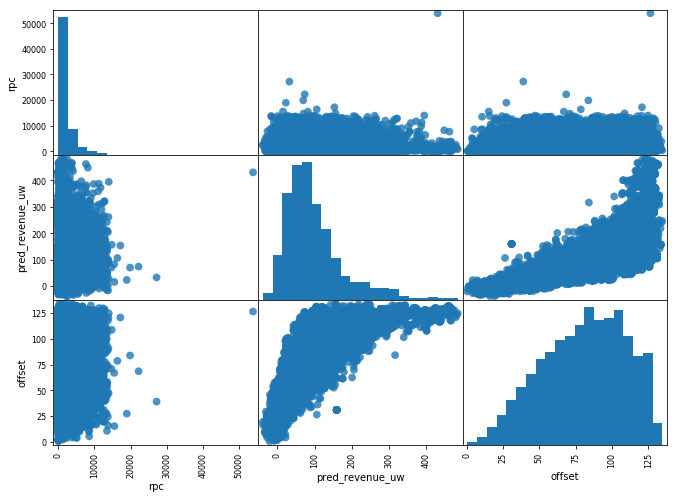

In [156]:
tmp = validate[validate['rpc'] > 0, ['rpc', 'pred_revenue_uw', 'offset']].as_data_frame()

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

p = pd.plotting.scatter_matrix(tmp, figsize=(11, 8), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.8)

### Use simple deep learning model:

In [313]:
tt, _  = train.split_frame([.01], seed=2014)
tt.nrows

66782

In [50]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

lm_model = H2OGeneralizedLinearEstimator(family="gaussian", 
                                          lambda_=1.668101e-06, 
                                          standardize=True,
                                          alpha=1.0,
                                          max_iterations=100)

lm_model.train(predictors, 'm', training_frame=train, validation_frame=validate, weights_column = 'n_orig')

glm Model Build progress: |███████████████████████████████████████████████| 100%


/home/ubuntu/.local/share/virtualenvs/ml-rpc-LO9Wo36E/lib/python3.5/site-packages/h2o/job.py:69: UserWarning: Reached maximum number of iterations 100!
  warnings.warn(w)


In [51]:
print(lm_model.rmse(train=True))
print(lm_model.rmse(valid=True))

486.7066268206049
493.6666899268249


In [53]:
lm_model_pred = lm_model.predict(validate)

validate['pred_revenue'] = lm_model_pred
validate['pred_revenue_uw'] = lm_model_pred

# evaluate target metrics:

frame = validate
model_1_err1 = ((frame['pred_revenue'] - frame['m']) * (frame['pred_revenue'] - frame['m']) * frame['n']).sum() / frame['n'].sum()
model_1_err2 = np.sqrt(model_1_err1)

model_1_err1_uw = ((frame['pred_revenue_uw'] - frame['m']) * (frame['pred_revenue_uw'] - frame['m']) * frame['n_orig']).sum() / frame['n_orig'].sum()
model_1_err2_uw = np.sqrt(model_1_err1_uw)

print('RMSE: {:.2f}$'.format(model_1_err2))
print('RMSE (unweighted): {:.2f}$'.format(model_1_err2_uw))

glm prediction progress: |████████████████████████████████████████████████| 100%
RMSE: 3017.17$
RMSE (unweighted): 493.67$


### Summary

- two stage models do not really work! (unless first level is very, very accurate)
- Always use simpler model from the very beginning that will open the road to smart feature engineering
    - average rev per campaign
    - avreage rev per account etcc
- All in all sampling and weighting can make a process much faste
- Balancing is a good idea but not in two step models (too much to be done in the end)
- Workflow with Sparkling water is very robust and enables to leverage a lot of Python libraries (scikit-learn, scipy)
- deep learning is not super fast (even on fast machine) so for big datasets like this one would probably still use XGboost

